# Building an AI agent with Strands Agents SDK and Amazon Bedrock

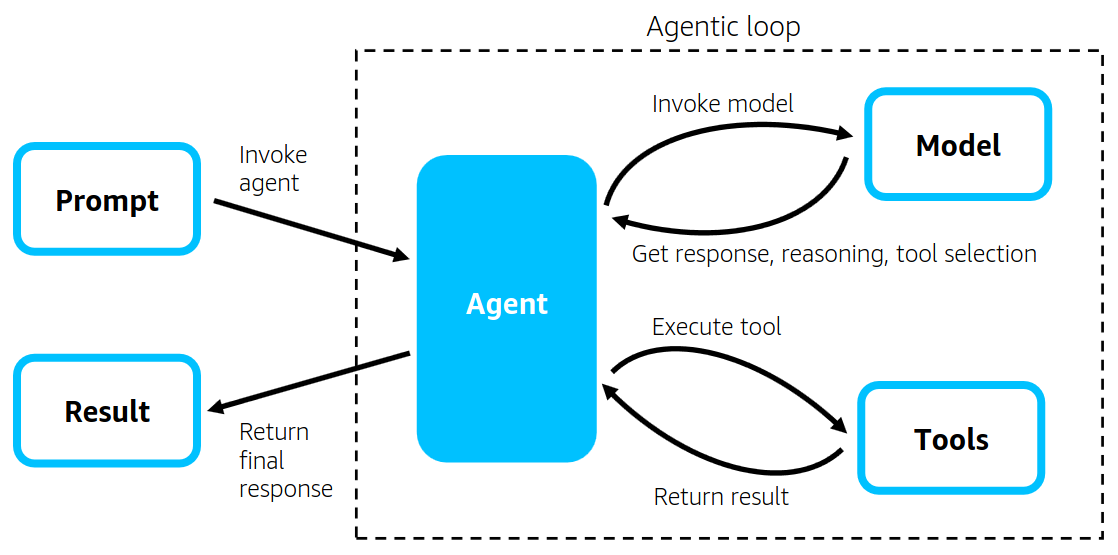

Building an AI agent with Strands Agents SDK is a straightforward process that centers around three fundamental components: a model, tools, and a prompt. To create an agent, developers first need to define these elements in their code. The model can be selected from various supported options, including Amazon Bedrock models with tool use and streaming capabilities, Anthropic's Claude model family, Ollama for local development, or other providers through LiteLLM. For tools, developers can choose from thousands of published Model Context Protocol (MCP) servers or utilize Strands' 20+ pre-built example tools for tasks like file manipulation, API requests, and AWS API interactions. Any Python function can be transformed into a tool using the Strands @tool decorator. The prompt consists of both a natural language prompt defining the agent's task and a system prompt providing general instructions and desired behavior. Once these components are defined, the agent operates in a loop, interacting with its model and tools until the task is completed. The Strands agentic loop leverages the advanced capabilities of modern LLMs to reason, plan, and select tools appropriately. To learn more about Strands Agents, head over to the announcement blog.

In this notebook, we will focus on how to build a Strands Agent.

In [ ]:
%pip install strands-agents strands-agents-tools duckduckgo-search -qU

<div class="alert alert-block alert-info">
⚠️ Make sure to restart the kernel after running the cell above.
</div>

## Agent Development

The agent loop is the process by which a Strands agent processes user input, makes decisions, executes tools, and generates responses. It's designed to support complex, multi-step reasoning and actions with seamless integration of tools and language models.

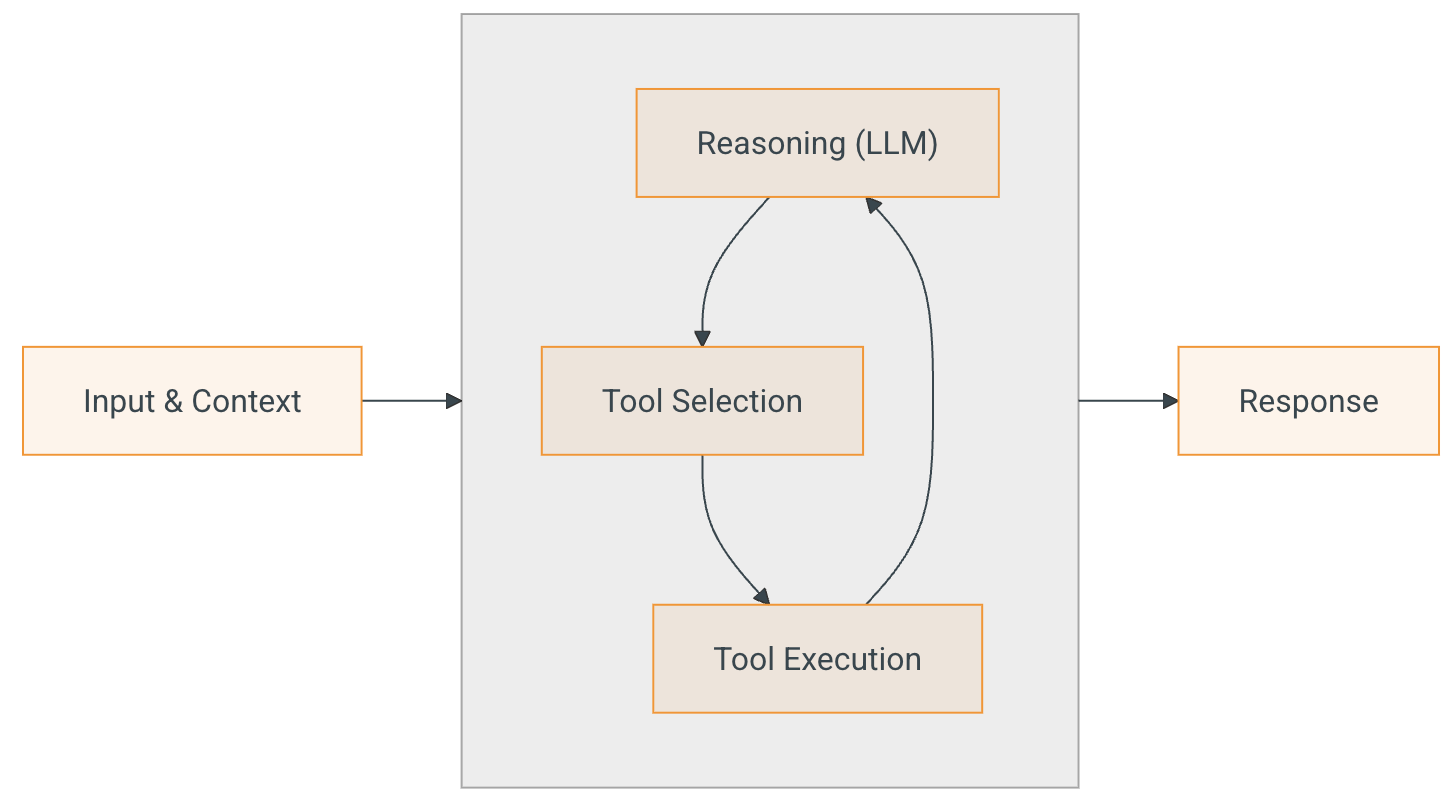

In [ ]:
from strands.models.bedrock import BedrockModel

model = BedrockModel(model_id="us.amazon.nova-pro-v1:0")

In [ ]:
from strands import Agent

agent = Agent(model=model)
agent("What is a 'trullo'?")

### Augment agents with tools

In [ ]:
from strands_tools import calculator, python_repl
import os

os.environ["BYPASS_TOOL_CONSENT"] = "true" # Required to have the agent execute the Python code

agent = Agent(
    model=model,
    tools=[
        calculator,
        python_repl,
    ],
    system_prompt="You are a helpful assistant. You can use the tools to help you with your task.",
)
agent("Write the code to create a custom calculator in Python, then test it and compare the results with the calculator tool provided.")

Strands Agents also support custom tools.

In [ ]:
from strands import tool
from duckduckgo_search import DDGS


# Define custom tool
@tool
def web_search(query:str, max_results=5)->dict:
    results = ""
    with DDGS() as ddgs:
        results = [r for r in ddgs.text(query, max_results=max_results)]
    return results

# Define the agent with the tools
agent = Agent(model=model, tools=[web_search])
response = agent("Who is the current #1 tennis player in the world?")

## Multi-Agent Workflows

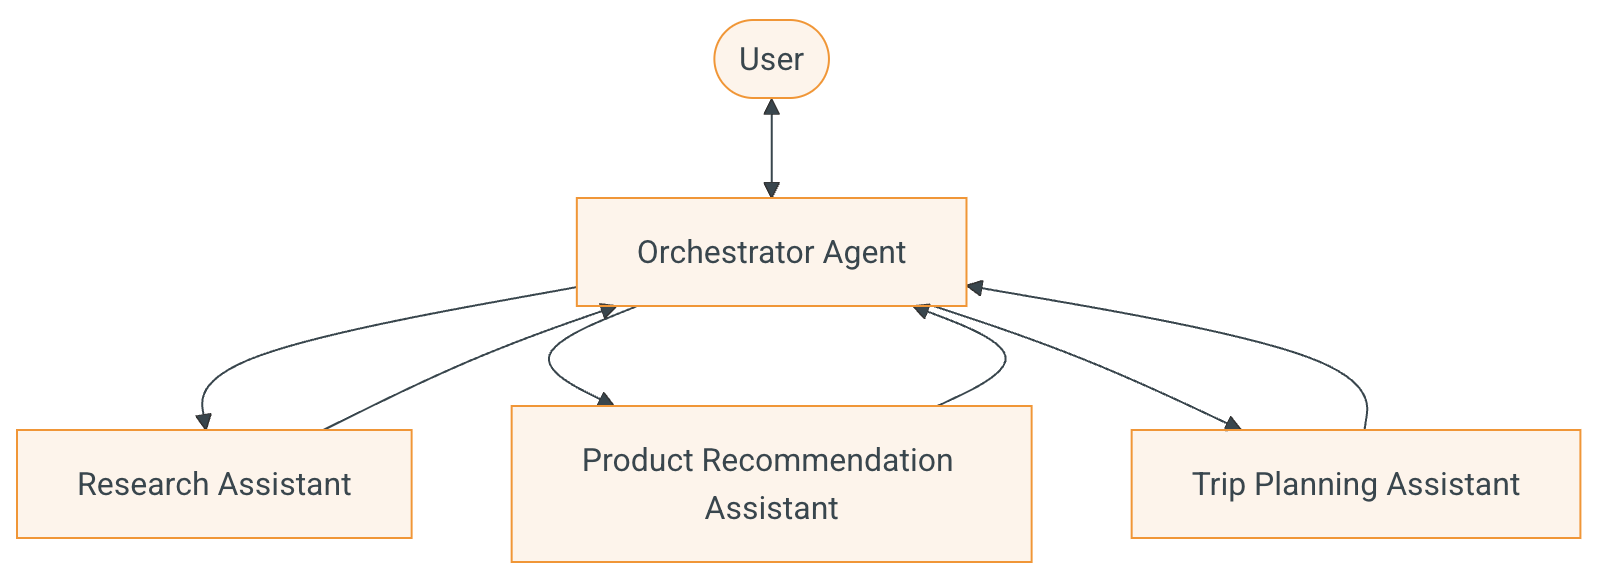

Strands Agents uses "Agents as Tools" as multi-agent workflow. It is an architectural pattern in AI systems where specialized AI agents are wrapped as callable functions (tools) that can be used by other agents. This creates a hierarchical structure where:

- A primary "orchestrator" agent handles user interaction and determines which specialized agent to call
- Specialized "tool agents" perform domain-specific tasks when called by the orchestrator

This approach mimics human team dynamics, where a manager coordinates specialists, each bringing unique expertise to solve complex problems. Rather than a single agent trying to handle everything, tasks are delegated to the most appropriate specialized agent.

In [ ]:
from textwrap import dedent

@tool
def research_assistant(query: str) -> str:
    researcher_agent = Agent(
        model=model,
        system_prompt=dedent(
            """You are an experienced travel researcher with a knack for 
            discovering both popular attractions and hidden gems in any 
            location. Your expertise lies in gathering comprehensive 
            information about various activities, their historical 
            significance, and practical details for visitors.
            Your goal is to research and compile interesting activities and attractions for a given location"""
        ),
        tools=[web_search]
    )
    return researcher_agent(query).message

@tool
def content_writer_assistant(query: str) -> str:
    content_writer = Agent(
        model=model,
        system_prompt=dedent(
            """You are a content writer with a knack for creating engaging 
            and informative content for travel blogs. Your expertise lies in 
            crafting engaging and informative content for travel blogs."
            Your goal is to write a listicle of 5 attractions/activities for a given location."""
        ),
    )
    return content_writer(query).message

@tool
def editor_assistant(query: str)->str:
    editor_agent = Agent(
        model=model,
        system_prompt=dedent(
            """You are a meticulous editor with years of experience in
            travel content. Your keen eye for detail helps polish articles
            to perfection. You focus on improving flow, maintaining
            consistency, and enhancing the overall readability of the
            content while ensuring it appeals to the target audience
            Your goal is to ensure the listicle is well-structured, engaging, and error-free."""
        ),
    )
    return editor_agent(query).message

In [ ]:
from strands import Agent

# Define orchestrator system prompt with clear tool selection guidance
MAIN_SYSTEM_PROMPT = """
You are an assistant that routes queries to specialized agents:
- For research questions and factual information → Use the research_assistant tool
- For product recommendations and shopping advice → Use the product_recommendation_assistant tool
- For travel planning and itineraries → Use the trip_planning_assistant tool
- For simple questions not requiring specialized knowledge → Answer directly

Always select the most appropriate tool based on the user's query.
"""

# Strands Agents SDK allows easy integration of agent tools
orchestrator = Agent(
    system_prompt=MAIN_SYSTEM_PROMPT,
    tools=[research_assistant, content_writer_assistant, editor_assistant]
)
orchestrator("I want to travel to Ceglie Messapica, Italy.")